In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from gensim.models import Word2Vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ------------------------------
# Load Reliance Stock Data
# ------------------------------
df=pd.read_csv(r"C:\Users\marat\OneDrive\Desktop\reliance_stock_data.csv")
# Rename columns for consistency
data = df.rename(columns={"title": "News", "sentiment": "Sentiment", "Stock price": "Stock_Price"})



# Check for NaN values
print(data.isna().sum())

# Remove rows with any NaN values
data = data.dropna()

# If you only want to fill NaN values in specific columns:
data['News'] = data['News'].fillna('No Data')  # For text columns
data['Stock_Price'] = data['Stock_Price'].fillna(data['Stock_Price'].mean())  # For numerical columns

# Check if NaN values are handled
print(data.isna().sum())

# Sentiment Calculation Using VADER

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment score using VADER
def calculate_sentiment_score(news):
    if isinstance(news, str):  # Ensure that the input is a string
        scores = analyzer.polarity_scores(news)
        return scores['compound']  # Use 'compound' as the overall sentiment score
    else:
        return None  # Return None for non-string values

# Apply the function to the 'News' column
data['Sentiment Score'] = data['News'].apply(calculate_sentiment_score)

# Display the updated DataFrame
print(data.iloc[0:500,:])


Date           792
Stock_Price    792
News           177
Sentiment      193
dtype: int64
Date           0
Stock_Price    0
News           0
Sentiment      0
dtype: int64
           Date  Stock_Price  \
0    03-01-2017   249.018509   
1    04-01-2017   243.932541   
2    05-01-2017   246.275513   
3    06-01-2017   245.715485   
4    09-01-2017   246.344086   
..          ...          ...   
495  03-01-2019   499.568542   
496  04-01-2019   502.265808   
497  07-01-2019   505.054535   
498  08-01-2019   505.008820   
499  09-01-2019   507.797516   

                                                  News Sentiment  \
0    Get ready for some fund manager churning. Meen...         1   
1    The Financial ExpressBharti Airtel chairman Su...         0   
2    The Financial ExpressReliance Jio has announce...         1   
3    MUMBAI: Reliance Retail is launching stores wh...         1   
4    New Delhi: The volume of wireless broadband da...         0   
..                                   

In [26]:
# ------------------------------
# Text Preprocessing
# ------------------------------
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Ensure input text is a string (in case it's mistakenly converted to a float or other types)
    if isinstance(text, str):
        tokens = nltk.word_tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        return " ".join(tokens)
    else:
        return ""

# Apply text preprocessing
data['Processed_News'] = data['News'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
# ------------------------------
# Word2Vec Embedding
# ------------------------------
# Train a Word2Vec model on the processed news
w2v_model = Word2Vec(sentences=data['Processed_News'], vector_size=100, window=5, min_count=1, workers=4)

# Create Word2Vec embeddings for each news entry by averaging word vectors
def get_average_word2vec(tokens, model, vector_size):
    if len(tokens) < 1:
        return np.zeros(vector_size)  # Return a zero vector for empty inputs
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)  # Return a zero vector if no tokens are in the model's vocabulary
    return np.mean(model.wv[valid_tokens], axis=0)

data['News_Embedding'] = data['Processed_News'].apply(lambda x: get_average_word2vec(x, w2v_model, 100))

# Convert the list of embeddings to a NumPy array
X_text = np.vstack(data['News_Embedding'].values)


In [15]:
data.head()

,Date,Stock_Price,News,Sentiment,Processed_News,News_Embedding,Scaled_Stock_Price
0,03-01-2017,249.018509,Get ready for some fund manager churning. Meen...,1,get ready fund manager churning meenakshi dawa...,"[-0.10707253, 0.3364816, 0.19280481, 0.2335804...",0.017803
1,04-01-2017,243.932541,The Financial ExpressBharti Airtel chairman Su...,0,financial expressbharti airtel chairman sunil ...,"[-0.11545926, 0.32552543, 0.17619133, 0.213965...",0.012414
2,05-01-2017,246.275513,The Financial ExpressReliance Jio has announce...,1,financial expressreliance jio ha announced 72 ...,"[-0.11576896, 0.30631813, 0.16207209, 0.200452...",0.014896
3,06-01-2017,245.715485,MUMBAI: Reliance Retail is launching stores wh...,1,mumbai reliance retail launching store woman b...,"[-0.1092448, 0.328667, 0.16749665, 0.21946084,...",0.014303
4,09-01-2017,246.344086,New Delhi: The volume of wireless broadband da...,0,new delhi volume wireless broadband data consu...,"[-0.12318787, 0.30133152, 0.17880152, 0.212469...",0.014969


In [29]:
# ------------------------------
# Scaling Stock Prices
# ------------------------------
scaler = MinMaxScaler()
data['Scaled_Stock_Price'] = scaler.fit_transform(data[['Stock_Price']])

# ------------------------------
# Splitting Data
# ------------------------------
X_sentiment = np.array(data['Sentiment Score']).reshape(-1, 1)  # Sentiment Scores from VADER
X_price = np.array(data['Scaled_Stock_Price']).reshape(-1, 1)
np.isnan(X_sentiment).any()
# Combine Word2Vec embeddings with sentiment scores
X_combined = np.hstack([X_text, X_sentiment])
y = X_price

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
np.isnan(X_train).any()
np.isnan(y_train).any()



False

In [30]:
# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# ------------------------------
# LSTM Model
# ------------------------------
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


C:\python123\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1768 - val_loss: 0.0747
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0793 - val_loss: 0.0602
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0690 - val_loss: 0.0596
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0704 - val_loss: 0.0593
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0658 - val_loss: 0.0587
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0658 - val_loss: 0.0585
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0680 - val_loss: 0.0584
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0648 - val_loss: 0.0582
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0635 - val_loss: 0.0581
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0697 - val_loss: 0.0579
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0679 - val_loss: 0.0580
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0648 - val_loss: 0.0578

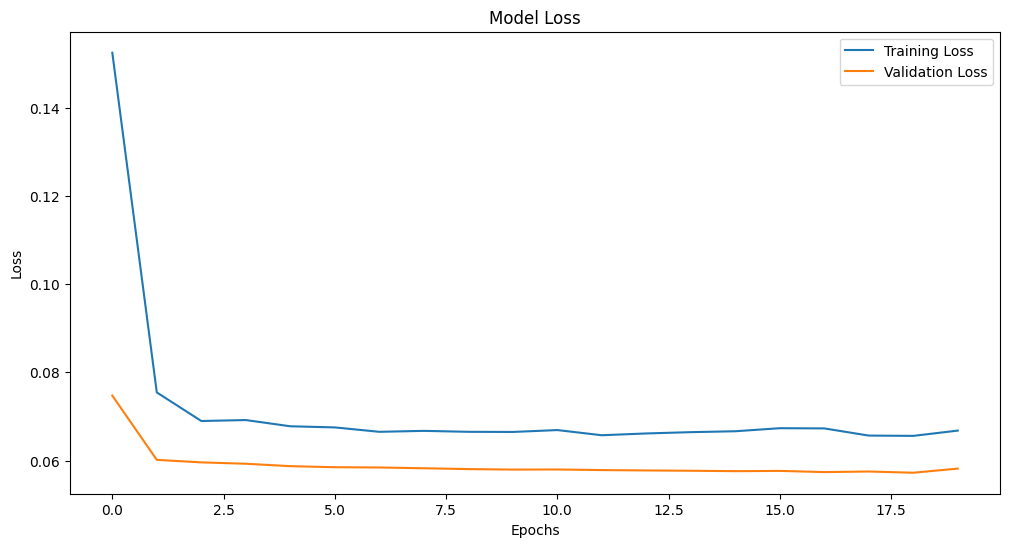

In [31]:
# ------------------------------
# Evaluation
# ------------------------------
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step 


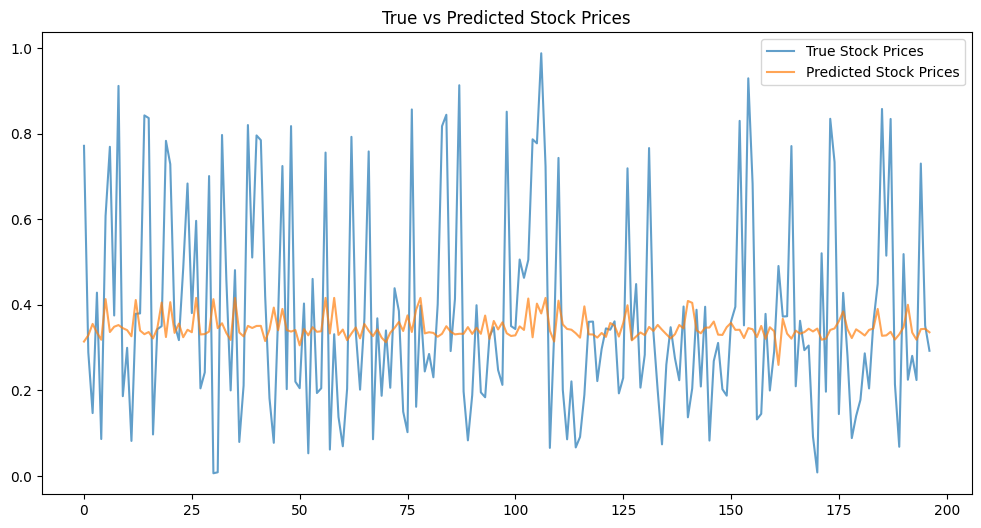

Mean Squared Error: 0.05816739859568937
R-squared: 0.0014979788894591284


In [32]:
# Predictions
y_pred = model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Stock Prices', alpha=0.7)
plt.plot(y_pred, label='Predicted Stock Prices', alpha=0.7)
plt.title('True vs Predicted Stock Prices')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")